In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from joblib import Parallel, delayed
from scipy.stats import pearsonr
import time
from scipy.stats import spearmanr, rankdata
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X = pd.read_csv(r"1.1-Output/ProcessedFeatures.csv")
y = pd.read_csv(r"1.1-Output/ProcessedLabels.csv")

In [3]:
y = LabelEncoder().fit_transform(y.values.ravel())
X.drop(columns=['ICMP Code', 'ICMP Type', 'Src Port', 'Dst Port', 'Protocol', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count'], inplace=True)

In [4]:
print(f"Shape of data: {X.shape}\nTarget classes: {np.unique(y)}")

Shape of data: (2099971, 76)
Target classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]


In [5]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=50000, random_state=42)
for sample_idx, _ in splitter.split(X.values, y):
    X_sampled, y_sampled = X.values[sample_idx], y[sample_idx]

n_features = X_sampled.shape[1]
print(f"Sampled shape: {X_sampled.shape}")

Sampled shape: (2049971, 76)


In [6]:
# Set sample size
sample_size = 50_000

# Stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=42)

# Perform the split
for _, sample_index in sss.split(X, y):
    if isinstance(X, pd.DataFrame):
        X_sampled = X.iloc[sample_index]
    else:
        X_sampled = X[sample_index]
        
    if isinstance(y, pd.Series):
        y_sampled = y.iloc[sample_index]
    else:
        y_sampled = y[sample_index]

In [7]:
n_features = X_sampled.shape[1]
print(f"Sampled shape: {X_sampled.shape}")
X_sampled_values = X_sampled.values

Sampled shape: (50000, 76)


#### PSO FITNESS FUNCTION

In [8]:
def spearman_corr_vectorized(X, y):
    """Compute absolute Spearman correlations of all columns in X with y"""
    X_ranked = np.apply_along_axis(rankdata, 0, X)
    y_ranked = rankdata(y)
    X_mean = X_ranked.mean(axis=0)
    y_mean = y_ranked.mean()

    X_demeaned = X_ranked - X_mean
    y_demeaned = y_ranked - y_mean

    numerator = np.sum(X_demeaned * y_demeaned[:, None], axis=0)
    denominator = np.sqrt(np.sum(X_demeaned ** 2, axis=0) * np.sum(y_demeaned ** 2))

    corr = numerator / denominator
    return np.abs(np.nan_to_num(corr))

In [9]:
# def evaluate_individual(individual, X, y, alpha=1.0, beta=1.0, gamma=0.5):
#     selected = np.where(individual == 1)[0]
#     if len(selected) == 0:
#         return -999.0  # Penalize empty feature sets

#     X_sel = X[:, selected]
#     valid = np.std(X_sel, axis=0) != 0
#     X_sel = X_sel[:, valid]
#     if X_sel.shape[1] == 0:
#         return -999.0

#     # Relevance
#     relevance = spearman_corr_vectorized(X_sel, y).mean()

#     # Redundancy
#     if X_sel.shape[1] > 1:
#         corr_matrix = np.corrcoef(X_sel, rowvar=False)
#         upper = np.triu_indices(X_sel.shape[1], k=1)
#         redundancy = np.nanmean(np.abs(corr_matrix[upper]))
#     else:
#         redundancy = 0

#     size_penalty = X_sel.shape[1] / X.shape[1]
#     return alpha * relevance - beta * redundancy - gamma * size_penalty

In [10]:
def evaluate_individual(individual, X, y, alpha=1.0, beta=1.0, gamma=0.5):
    """
    GA-style PSO fitness function with explicit Spearman loop and full control over:
    - alpha: relevance weight
    - beta: redundancy penalty
    - gamma: size penalty
    """

    start_time = time.time()
    selected_indices = [i for i, bit in enumerate(individual) if bit == 1]

    if len(selected_indices) == 0:
        return -999.0  # Penalize empty sets

    selected_X = X[:, selected_indices]

    # --- Relevance ---
    relevance_scores = []
    for i in range(len(selected_indices)):
        feature = selected_X[:, i]
        if np.std(feature) == 0:
            continue
        corr, _ = spearmanr(feature, y)
        if not np.isnan(corr):
            relevance_scores.append(abs(corr))
    relevance = np.nanmean(relevance_scores) if relevance_scores else 0

    # --- Redundancy ---
    if len(selected_indices) > 1:
        valid_cols = [i for i in range(selected_X.shape[1]) if np.std(selected_X[:, i]) != 0]
        if len(valid_cols) > 1:
            valid_X = selected_X[:, valid_cols]
            corr_matrix = np.corrcoef(valid_X, rowvar=False)
            upper_triangle = np.triu_indices(len(valid_cols), k=1)
            redundancy = np.mean(np.abs(corr_matrix[upper_triangle]))
        else:
            redundancy = 0
    else:
        redundancy = 0

    # --- Size Penalty ---
    size_penalty = len(selected_indices) / X.shape[1]

    # --- Final Score ---
    score = alpha * relevance - beta * redundancy - gamma * size_penalty
    print(f"Eval: {len(selected_indices)} features in {time.time() - start_time:.2f}s | "
          f"Relevance: {relevance:.4f} | Redundancy: {redundancy:.4f} | Score: {score:.4f}")
    
    return score

In [11]:
def evaluate_swarm(population, X, y, alpha=1.2, beta=1.5, gamma=0.5):
    return Parallel(n_jobs=-1)(
        delayed(evaluate_individual)(ind, X, y, alpha, beta, gamma)
        for ind in population
    )

#### IMPLEMENTATION

In [12]:
n_particles = 40
n_iterations = 100
# w_max, w_min = 0.9, 0.4
w = 0.9
c1, c2 = 1.49, 1.49

# Binary positions & continuous velocities
positions = np.random.randint(0, 2, size=(n_particles, n_features))
velocities = np.random.uniform(-1, 1, size=(n_particles, n_features))

# Personal and global bests
p_best_positions = positions.copy()
p_best_scores = np.full(n_particles, -999.0)
g_best_score = -np.inf
g_best_position = None

In [13]:
start = time.time()
for it in range(n_iterations):
    # w = w_max - (w_max - w_min) * (it / n_iterations)
    iter_start = time.time()

    scores = evaluate_swarm(positions, X_sampled_values, y_sampled)

    for i in range(n_particles):
        if scores[i] > p_best_scores[i]:
            p_best_scores[i] = scores[i]
            p_best_positions[i] = positions[i].copy()

        if scores[i] > g_best_score:
            g_best_score = scores[i]
            g_best_position = positions[i].copy()

    for i in range(n_particles):
        r1 = np.random.rand(n_features)
        r2 = np.random.rand(n_features)

        velocities[i] = (
            w * velocities[i]
            + c1 * r1 * (p_best_positions[i] - positions[i])
            + c2 * r2 * (g_best_position - positions[i])
        )

        sigmoid = 1 / (1 + np.exp(-velocities[i]))
        positions[i] = np.where(np.random.rand(n_features) < sigmoid, 1, 0)

    iter_time = time.time() - iter_start
    print(f"Iteration {it+1:02d}/{n_iterations} | Best Score: {g_best_score:.4f} | Selected Features: {np.sum(g_best_position)} | Time: {iter_time:.2f}s")

print(f"\nOptimization complete in {time.time() - start:.2f} seconds")

Iteration 01/100 | Best Score: -0.1524 | Selected Features: 30 | Time: 5.63s
Iteration 02/100 | Best Score: -0.0825 | Selected Features: 27 | Time: 3.87s
Iteration 03/100 | Best Score: -0.0808 | Selected Features: 29 | Time: 3.60s
Iteration 04/100 | Best Score: -0.0808 | Selected Features: 29 | Time: 3.45s
Iteration 05/100 | Best Score: -0.0769 | Selected Features: 24 | Time: 3.31s
Iteration 06/100 | Best Score: -0.0678 | Selected Features: 26 | Time: 3.26s
Iteration 07/100 | Best Score: -0.0678 | Selected Features: 26 | Time: 3.26s
Iteration 08/100 | Best Score: -0.0678 | Selected Features: 26 | Time: 3.29s
Iteration 09/100 | Best Score: -0.0361 | Selected Features: 26 | Time: 3.66s
Iteration 10/100 | Best Score: -0.0361 | Selected Features: 26 | Time: 3.18s
Iteration 11/100 | Best Score: -0.0235 | Selected Features: 25 | Time: 3.57s
Iteration 12/100 | Best Score: -0.0235 | Selected Features: 25 | Time: 3.55s
Iteration 13/100 | Best Score: -0.0235 | Selected Features: 25 | Time: 3.29s

In [14]:
selected_features = np.where(g_best_position == 1)[0]
selected_features_names = X.columns[selected_features]
print(f"Selected Features ({len(selected_features)}): {selected_features_names}")

Selected Features (11): Index(['Total Fwd Packet', 'Flow Bytes/s', 'Flow Packets/s', 'RST Flag Count',
       'Fwd Segment Size Avg', 'Bwd Packet/Bulk Avg', 'Subflow Fwd Bytes',
       'FWD Init Win Bytes', 'Fwd Act Data Pkts', 'Active Max',
       'Total TCP Flow Time'],
      dtype='object')


#### EVALUATION

In [15]:
from sklearn.feature_selection import mutual_info_classif

In [16]:
# Set sample size
sample_size = 200_000

# Stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=42)

# Perform the split
for _, sample_index in sss.split(X, y):
    if isinstance(X, pd.DataFrame):
        X_eval = X.iloc[sample_index]
    else:
        X_eval = X[sample_index]
        
    if isinstance(y, pd.Series):
        y_eval = y.iloc[sample_index]
    else:
        y_eval = y[sample_index]

        
X_eval_values = X_eval[selected_features_names].values
X_eval_best = X_eval[selected_features_names]

In [17]:
mi = mutual_info_classif(X_eval_values, y_eval, discrete_features='auto')
print(f"\nMean Mutual Information (MI): {np.mean(mi):.4f}")


Mean Mutual Information (MI): 0.4473


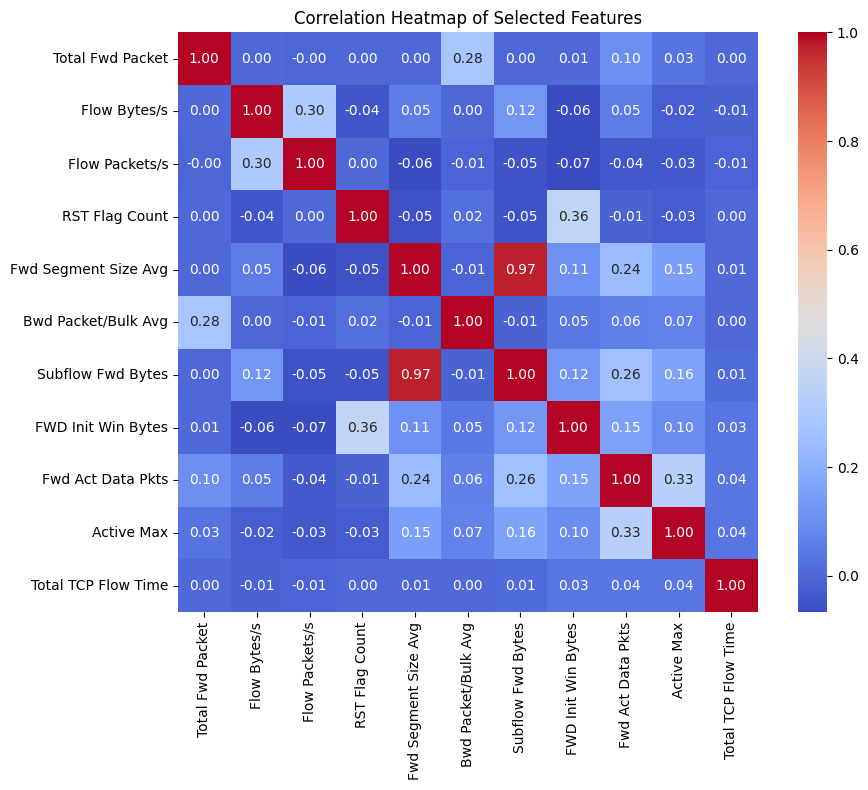

In [18]:
plt.figure(figsize=(10, 8))
corr_matrix = X_eval_best.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Correlation Heatmap of Selected Features")
plt.tight_layout()
plt.show()

In [19]:
# Set sample size
sample_size = 10_000

# Stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=42)

# Perform the split
for _, sample_index in sss.split(X, y):
    if isinstance(X, pd.DataFrame):
        X_vis = X.iloc[sample_index]
    else:
        X_vis = X[sample_index]
        
    if isinstance(y, pd.Series):
        y_vis = y.iloc[sample_index]
    else:
        y_vis = y[sample_index]

X_vis_values = X_vis[selected_features_names].values

In [20]:
from openTSNE import TSNE

# Run openTSNE
tsne = TSNE(
    n_jobs=8,  # parallel processing
    perplexity=30,
    metric="euclidean",
    random_state=42
)
X_tsne = tsne.fit(X_vis_values)

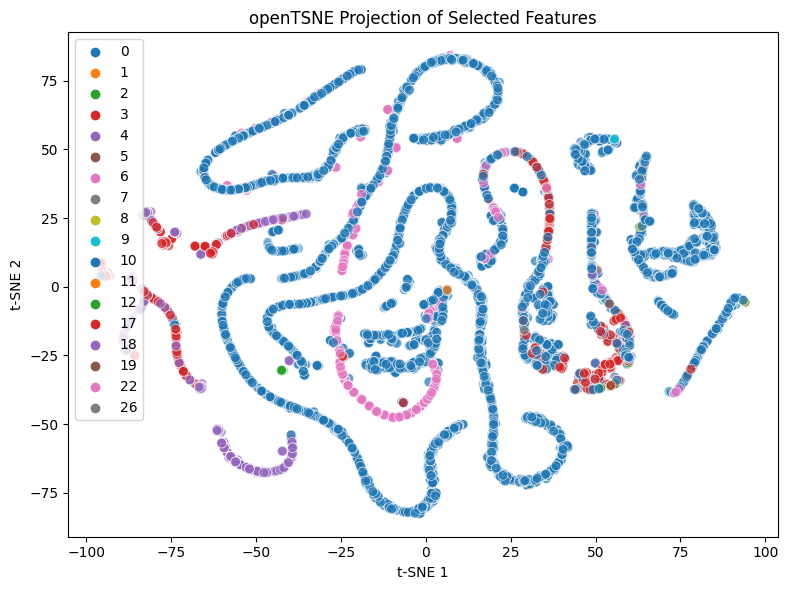

In [21]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_vis, palette='tab10', s=50, alpha=0.7)
plt.title("openTSNE Projection of Selected Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()